# Experiment 1

### This python notebook generates the results and computes statistics for Experiment 1

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import scipy
import scipy.io as sio
import scikits.bootstrap as bootstrap  
import statsmodels.api as sm

from paper_statistics import resamplingStatistics, paramStatistics
from paper_plotting import make_plot_pretty, savefig, plotSpread
from paper_behavior import aprime, find_freq_categ, convertKey2Resp

In [2]:
%matplotlib inline 

plt.rcParams.update({'font.size': 14})
rc('text', usetex=False)

if os.path.isfile("/Library/Fonts/HelveticaNeue.ttf"): prop = fm.FontProperties(fname='/Library/Fonts/HelveticaNeue.ttf')
else: prop = fm.FontProperties(fname='/Library/Fonts/Arial.ttf')

In [3]:
#preset some experiment details

#subject numbers
subjNums = np.array([51,52,53,54,55,56,57,58,59,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83])
#note: subject 60 excluded due to poor behavior (>3 standard deviations below mean)

#total number of subjects
nSubj = subjNums.size 

#experiment details
nTrials = 500

#data file directory
dataDir = 'data_expt1/' 
figDir = 'figures/' #directory to save figures

nSamples = 100000 # number of resampling iterations 

In [4]:
#sustained attention phase: load data, and compute overall behavioral performance metrics

#preallocate some variables
categs = {}
categFreq, categInfreq = np.ones([nSubj]).astype(int)*-1, np.ones([nSubj]).astype(int)*-1
trialsFreq, trialsInfreq = {}, {}
accs, accsFreq, accsInfreq = {}, {}, {}
h, cr = np.empty(nSubj) * np.nan, np.empty(nSubj) * np.nan

for iSubj in range(0,nSubj):
    #directory where data is stored
    subjDir = dataDir + str(int(subjNums[iSubj])) + '/'
    
    #load files
    fn = glob.glob( ( subjDir + 'blockdata*' ) )
    matContents = sio.loadmat(fn[0],struct_as_record=False)
    attData = matContents['blockData']

    #category of all trials (1=scenes, 2 = faces)
    categs[iSubj] = attData[0,0].categs[0]
    
    #determine which category was frequent, and which was infrequent by calculating the mode across all trials
    categFreq[iSubj],categInfreq[iSubj] = find_freq_categ(categs[iSubj])
    
    #locations of frequent and infrequent trials
    trialsFreq[iSubj] = np.where(np.equal(categs[iSubj],categFreq[iSubj]))[0]
    trialsInfreq[iSubj] = np.where(np.equal(categs[iSubj],categInfreq[iSubj]))[0]
    
    #behavioral accuracy of all trials (1 = correct, 0 = incorrect)
    accs[iSubj] = attData[0,0].accs[0]
    
    #accuracy of frequent and infrequent trials
    accsFreq[iSubj] = [accs[iSubj][i] for i in trialsFreq[iSubj]]
    accsInfreq[iSubj] = [accs[iSubj][i] for i in trialsInfreq[iSubj]]

    #summary of sustained attention performance
    h[iSubj] = np.mean([accs[iSubj][i] for i in trialsFreq[iSubj]]) #hit rate
    cr[iSubj] = np.mean([accs[iSubj][i] for i in trialsInfreq[iSubj]]) #correct rejection rate
    
m = np.subtract(1,h) #miss rate
fa = np.subtract(1,cr) #false alarm rate

A = aprime(h,fa) #aprime

#compute confidence intervals for sustained attention performance
h_CIs = bootstrap.ci(data=(h), statfunction=scipy.mean,n_samples=nSamples)
m_CIs = bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=nSamples)
fa_CIs = bootstrap.ci(data=(fa), statfunction=scipy.mean,n_samples=nSamples)
cr_CIs = bootstrap.ci(data=(cr), statfunction=scipy.mean,n_samples=nSamples)
A_CIs = bootstrap.ci(data=(A), statfunction=scipy.mean,n_samples=nSamples)

#print overall sustained attention performance
print "Overall sustained attention phase performance:"
print "\t Hit rate =\t%.2f, \t95%% CIs %.2f,%.2f " % ( np.ndarray.mean(h) , h_CIs[0] , h_CIs[1] )
print "\t Miss rate =\t%.2f, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(m) , m_CIs[0] , m_CIs[1] )
print "\t FA rate =\t%.2f, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(fa) , fa_CIs[0] , fa_CIs[1] )
print "\t CR rate =\t%.2f, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(cr) , cr_CIs[0] , cr_CIs[1] )
print "\t A' = \t\t%.2f, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(A) , A_CIs[0] , A_CIs[1] )

Overall sustained attention phase performance:
	 Hit rate =	0.98, 	95% CIs 0.97,0.98 
	 Miss rate =	0.02, 	95% CIs 0.02,0.03
	 FA rate =	0.30, 	95% CIs 0.26,0.34
	 CR rate =	0.70, 	95% CIs 0.66,0.74
	 A' = 		0.92, 	95% CIs 0.90,0.93


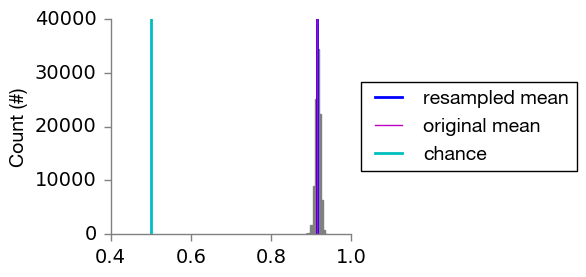

Sustained attention performance (A') vs chance (.5): p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.12
Parametric statistical result: T = 72.1, p = 4.4E-36


In [5]:
# Compute statistics on sustained attention behavior sensitivity

data = A
chance = .5

#nonparametric statistics - resampling participants with replacement
resampledA,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Sustained attention performance (A') vs chance (.5): p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

Error rate for infrequent trials: 0.30
Error rate for frequent trials: 0.02


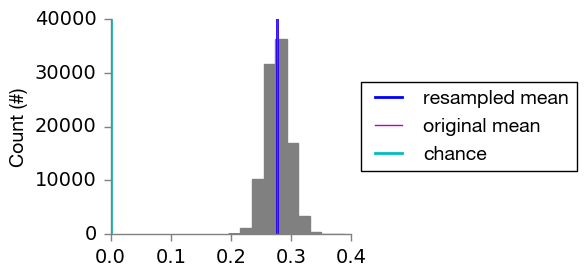

Error rate greater for infrequent trials vs frequent trials: p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.17
Parametric statistical result: T = 14.2, p = 4.1E-15


In [6]:
# Compute statistics on error rate (differences between frequent and infrequent trials)

print("Error rate for infrequent trials: %.2f" %np.mean(fa))
print("Error rate for frequent trials: %.2f" %np.mean(m))

errDiff = fa - m

data = errDiff 
chance = 0

#nonparametric statistics - by resampling participants with replacement
resampledErrDiff,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Error rate greater for infrequent trials vs frequent trials: p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

In [7]:
#Calculate RT difference for preceding trials of various shifts

rts, rtsDetrend = {},{}
prevRTsInfreq_Shifts, prevRTsInfreq_ShiftMean = {},{}
prevRTsDetrendInfreq_Shifts, prevRTsDetrendInfreq_ShiftMean = {},{}
trialsWithResponses, linfit = {},{}

nShifts = 3 #number of trials to include in analyses before an infrequent trial

for iSubj in range(0,nSubj):  
    iSubjNum = subjNums[iSubj]
    subjDir = dataDir + str(int(subjNums[iSubj])) + '/'

    #load subject data
    fn = glob.glob( ( subjDir + 'blockdata*' ) )
    matContents = sio.loadmat(fn[0],struct_as_record=False)
    attData = matContents['blockData']
    
    #rts for entire sustained attention phase
    rts[iSubj] = attData[0,0].rts[0]
    
    #compute linear fit of rts for trials with responses
    trials = attData[0,0].trial[0]
    trialsWithResponses[iSubj] = np.where(~np.isnan(rts[iSubj]))[0]
    linfit[iSubj] = np.polyfit(trials[trialsWithResponses[iSubj]],rts[iSubj][trialsWithResponses[iSubj]],1)

    #subtract linear fit
    rtsDetrend[iSubj] = rts[iSubj] - (linfit[iSubj][0]*trials+linfit[iSubj][1])
    
    #pre-allocate variables
    prevRTsInfreq_Shifts[iSubj] = np.empty([nShifts,np.size(trialsInfreq[iSubj])])*np.NAN
    prevRTsDetrendInfreq_Shifts[iSubj] = np.empty([nShifts,np.size(trialsInfreq[iSubj])])*np.NAN
    
    #loop through the various shifts
    for iShift in range(1,(nShifts+1)):
        #shift backwards the locations of the infrequent trial
        trialsInfreq_Shifted = np.subtract(trialsInfreq[iSubj],iShift)
        
        #exclude those trials that, when shifted, are before the start of the run
        wherePos_MaxShifted = np.where(trialsInfreq_Shifted>=0)[0]
        
        #replace the row with the rts (corresponding to that shift)
        prevRTsInfreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rts[iSubj][trialsInfreq_Shifted[wherePos_MaxShifted]]

        #replace the row with the detrended rts (corresponding to that shift)
        prevRTsDetrendInfreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rtsDetrend[iSubj][trialsInfreq_Shifted[wherePos_MaxShifted]]

    #calculate the mean over all shifts
    prevRTsInfreq_ShiftMean[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj],axis=0)
    prevRTsDetrendInfreq_ShiftMean[iSubj] = np.nanmean(prevRTsDetrendInfreq_Shifts[iSubj],axis=0)

/Users/megan/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [8]:
#compte RTs for correct and incorrect responses (average across all shifts)

prevRTsInfreq_ShiftMean_Cor, prevRTsInfreq_ShiftMean_Err = np.empty(nSubj),np.empty(nSubj)
prevRTsDetrendInfreq_ShiftMean_Cor, prevRTsDetrendInfreq_ShiftMean_Err = np.empty(nSubj),np.empty(nSubj)

for iSubj in range(0,nSubj):  
    prevRTsInfreq_ShiftMean_Cor[iSubj] = np.nanmean(prevRTsInfreq_ShiftMean[iSubj][np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
    prevRTsInfreq_ShiftMean_Err[iSubj] = np.nanmean(prevRTsInfreq_ShiftMean[iSubj][np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])

    prevRTsDetrendInfreq_ShiftMean_Cor[iSubj] = np.nanmean(prevRTsDetrendInfreq_ShiftMean[iSubj][np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
    prevRTsDetrendInfreq_ShiftMean_Err[iSubj] = np.nanmean(prevRTsDetrendInfreq_ShiftMean[iSubj][np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])
    
#convert RT from s to ms
prevRTsInfreq_ShiftMean_Cor_ms = prevRTsInfreq_ShiftMean_Cor*1000 
prevRTsInfreq_ShiftMean_Err_ms = prevRTsInfreq_ShiftMean_Err*1000 

#RT diff (acc - err) [ms]
rtDiff = prevRTsInfreq_ShiftMean_Cor_ms - prevRTsInfreq_ShiftMean_Err_ms

#compute confidence intervals
prevRTsInfreq_ShiftMean_Cor_ms_CIs = bootstrap.ci(data=(prevRTsInfreq_ShiftMean_Cor_ms), statfunction=scipy.mean,n_samples=nSamples)
prevRTsInfreq_ShiftMean_Err_ms_CIs = bootstrap.ci(data=(prevRTsInfreq_ShiftMean_Err_ms), statfunction=scipy.mean,n_samples=nSamples)

#print results for RTs before correct/incorrect responses
print "RTs are slower before correct responses than before incorrect responses:"
print "\t RTs preceding correct responses =\t%.0f ms, 95%% CIs %.0f,%.0f" % ( np.ndarray.mean(prevRTsInfreq_ShiftMean_Cor_ms) , prevRTsInfreq_ShiftMean_Cor_ms_CIs[0] , prevRTsInfreq_ShiftMean_Cor_ms_CIs[1] )
print "\t RTs preceding incorrect responses =\t%.0f ms, 95%% CIs %.0f,%.0f" % ( np.ndarray.mean(prevRTsInfreq_ShiftMean_Err_ms) , prevRTsInfreq_ShiftMean_Err_ms_CIs[0] , prevRTsInfreq_ShiftMean_Err_ms_CIs[1] )

RTs are slower before correct responses than before incorrect responses:
	 RTs preceding correct responses =	520 ms, 95% CIs 502,537
	 RTs preceding incorrect responses =	446 ms, 95% CIs 422,471


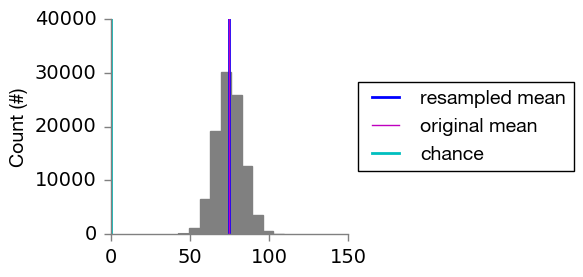

RTs faster before errors: p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.13
Parametric statistical result: T = 8.7, p = 7.5E-10


In [9]:
#Compute statistics on preceding RT difference (correct minus incorrect)

data = prevRTsInfreq_ShiftMean_Cor_ms - prevRTsInfreq_ShiftMean_Err_ms 
chance = 0

#nonparametric statistics - by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "RTs faster before errors: p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

In [10]:
#Compute statistics on preceding lags separately 

nShifts =3

tempmeanCor = np.empty(nSubj)*np.nan
tempmeanErr = np.empty(nSubj)*np.nan
RTdiff_IndividTrials = np.empty([nShifts,nSubj])
pRTdiff_IndividTrials = np.empty(nShifts)
RTdiff_IndividTrials_CIs = np.empty([nShifts,2])

for iShift in range(0,nShifts):
    print "Trials i-%i before the infrequent trial:" %(iShift+1)
    for iSubj in range(0,nSubj):
        tempmeanCor[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
        tempmeanErr[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])
    RTdiff_IndividTrials[iShift,:] = (tempmeanCor - tempmeanErr)*1000
    data = (tempmeanCor - tempmeanErr)*1000
    chance = 0
    
    #confidence intervals
    RTdiff_IndividTrials_CIs[iShift,:] = bootstrap.ci(data=(RTdiff_IndividTrials[iShift,:]), statfunction=scipy.mean,n_samples=nSamples)
    
    #nonparametric statistics - by resampling participants with replacement
    resampled,p = resamplingStatistics(data,chance,nSubj,nSamples,skipfig=1)
    pRTdiff_IndividTrials[iShift] = p
    print "RTs %.2f ms faster before errors: p = %.2E" % (np.mean(data), p )
    
    
    #parametric statistics
    paramStatistics(data,chance)
    
    print " "

Trials i-1 before the infrequent trial:
RTs 97.87 ms faster before errors: p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.86
Parametric statistical result: T = 10.5, p = 9.3E-12
 
Trials i-2 before the infrequent trial:
RTs 70.32 ms faster before errors: p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.16
Parametric statistical result: T = 8.1, p = 3.4E-09
 
Trials i-3 before the infrequent trial:
RTs 58.28 ms faster before errors: p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.45
Parametric statistical result: T = 7.3, p = 3.0E-08
 


In [11]:
#Compute statistics between trial lags - is there an RT difference between lags

tempmeanCor = np.empty(nSubj)*np.nan
tempmeanErr = np.empty(nSubj)*np.nan

for iShift in range(0,nShifts-1):
    for iSubj in range(0,nSubj):
        tempmeanCor[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
        tempmeanErr[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])
    data1 = (tempmeanCor - tempmeanErr)*1000
    
    for iSubj in range(0,nSubj):
        tempmeanCor[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj][iShift+1,np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
        tempmeanErr[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj][iShift+1,np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])
    data2 = (tempmeanCor - tempmeanErr)*1000
    
    chance = 0
    
    #nonparametric statistics - by resampling participants with replacement
    resampled,p = resamplingStatistics(data1-data2,chance,nSubj,nSamples,skipfig=1)
    print "Trials i-%i > i-%i before the infrequent trial, p = %.5f\n" % ( iShift+1, iShift+2, p)

Trials i-1 > i-2 before the infrequent trial, p = 0.00001

Trials i-2 > i-3 before the infrequent trial, p = 0.00978



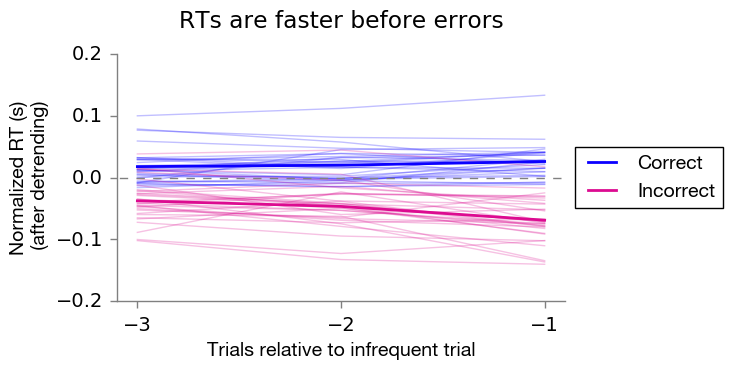

In [12]:
#plot how preceding RT relates to accuracy (Figure 2a)

tempmeanCor = np.empty([nShifts,nSubj])*np.nan
tempmeanErr = np.empty([nShifts,nSubj])*np.nan

for iShift in range(0,nShifts):
    for iSubj in range(0,nSubj):
        tempmeanCor[iShift,iSubj] = np.nanmean(prevRTsDetrendInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
        tempmeanErr[iShift,iSubj] = np.nanmean(prevRTsDetrendInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])

#print np.nanmean(tempmeanCor,axis=1)
ax = plt.subplot(111)
plt.plot([-1,-2,-3],tempmeanCor,color=[11./255,0,255./255],linewidth=1,alpha=0.25)
plt.plot([-1,-2,-3],tempmeanErr,color=[220./255,11./255,144./255],linewidth=1,alpha=0.25)
plt.plot([-1,-2,-3],np.mean(tempmeanCor,axis=1),color=[11./255,0,255./255],linewidth=2,label='Correct')
plt.plot([-1,-2,-3],np.mean(tempmeanErr,axis=1),color=[220./255,11./255,144./255],linewidth=2,label='Incorrect')
plt.plot((-3.5,-0.5),(0,0),'--', color='gray',linewidth=1)  

make_plot_pretty(ax,ylrot=90,yl='Normalized RT (s)\n (after detrending)',xlim=(-3.1,-.9),ylim=([-.2,.2]),xt=([-3,-2,-1]),
                 xl=('Trials relative to infrequent trial'),
                 t='RTs are faster before errors',
                 legend='1') 
plt.show()

In [13]:
#effect of using difference window sizes: calculate RT difference for different window sizes

maxWindow = 5
RTdiff_windowSize = np.empty([maxWindow,nSubj])
for windowSize in range(0,maxWindow):
    nShifts = windowSize+1
    for iSubj in range(0,nSubj):      
        #pre-allocate variables
        tempShifts = np.empty([nShifts,np.size(trialsInfreq[iSubj])])*np.NAN

        #loop through the various shifts
        for iShift in range(1,(nShifts+1)):
            #shift backwards the locations of the infrequent trial
            trialsInfreq_Shifted = np.subtract(trialsInfreq[iSubj],iShift)

            #exclude those trials that, when shifted, are before the start of the run
            wherePos_MaxShifted = np.where(trialsInfreq_Shifted>=0)[0]

            #replace the row with the rts (corresponding to that shift)
            if nShifts==1:
                tempShifts = rts[iSubj][trialsInfreq_Shifted[wherePos_MaxShifted]]
            else:
                tempShifts[iShift-1,wherePos_MaxShifted] = rts[iSubj][trialsInfreq_Shifted[wherePos_MaxShifted]]

        #calculate the mean over all shifts
        if np.shape(tempShifts)==(50,):
            tempShiftMean = tempShifts
        else:
            tempShiftMean = np.nanmean(tempShifts,axis=0)            
         
        tempShiftMean_Cor = np.nanmean(tempShiftMean[np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
        tempShiftMean_Err = np.nanmean(tempShiftMean[np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])

        RTdiff_windowSize[nShifts-1,iSubj] = (tempShiftMean_Cor-tempShiftMean_Err)*1000

In [14]:
#calculate statistics using different window sizes

pRTDiffWindowSize = np.empty(maxWindow)

for windowSize in range(0,maxWindow):
    data = RTdiff_windowSize[windowSize,:]
    chance = 0
    
    #non-parametric statistics
    resampled,p = resamplingStatistics(data,chance,nSubj,nSamples,skipfig=1)
    pRTDiffWindowSize[windowSize] = p
    print "Trailing window size = %i:" %(windowSize+1)
    
    print "RTdiff = %.2f, p = %.2E" % (np.mean(RTdiff_windowSize[windowSize,:]), p )
    
    #parametric statistics
    paramStatistics(data,chance)
    
    print " "

Trailing window size = 1:
RTdiff = 97.87, p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.86
Parametric statistical result: T = 10.5, p = 9.3E-12
 
Trailing window size = 2:
RTdiff = 84.37, p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.39
Parametric statistical result: T = 9.1, p = 2.8E-10
 
Trailing window size = 3:
RTdiff = 74.61, p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.13
Parametric statistical result: T = 8.7, p = 7.5E-10
 
Trailing window size = 4:
RTdiff = 68.61, p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.21
Parametric statistical result: T = 8.6, p = 9.9E-10
 
Trailing window size = 5:
RTdiff = 61.92, p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.23
Parametric statistical result: T = 8.1, p = 3.9E-09
 


In [15]:
#Subsequent memory data: load data, compute overall behavioral performance per participant

#high-confidence old resps only
thresh = 4 

#preallocate variables
memCategs, memResps, attOrder, nTrialsPerCateg = {},{},{},{}
hFreq,faFreq,hInfreq,faInfreq = np.empty(nSubj),np.empty(nSubj),np.empty(nSubj),np.empty(nSubj)

for iSubj in range(0,nSubj):
    iSubjNum = subjNums[iSubj]
    subjDir = dataDir + str(int(subjNums[iSubj])) + '/'
    
    fn = glob.glob( ( subjDir + 'memdata*' ) )
    matContents = sio.loadmat(fn[0],struct_as_record=False)
    memData = matContents['memData']
    
    memCategs[iSubj] = memData[0,0].memCategs[0] #memory category, 1 = old freq, 2 = old infreq, 3 = new freq, 4 = new infreq
    keys = memData[0,0].resps #which response the participant made
    
    memResps[iSubj] = np.array(map(convertKey2Resp,keys[0])) #convert from keycode to response number
    
    attOrder[iSubj] = memData[0,0].attOrder[0]
    
    #number of trials per memory category
    nTrialsPerCateg[iSubj] = [np.sum(np.equal(memCategs[iSubj],i+1)) for i in range(0,4)]
    
    #resps per memory category
    respsFrequentOld = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],1))[0]]
    respsInfrequentOld = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],2))[0]]
    respsFrequentNew = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],3))[0]]
    respsInfrequentNew = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],4))[0]]
    
    hFreq[iSubj] = float(np.sum(np.greater_equal(respsFrequentOld,thresh))) / float(nTrialsPerCateg[iSubj][0])
    faFreq[iSubj] =float(np.sum(np.greater_equal(respsFrequentNew,thresh))) / float(nTrialsPerCateg[iSubj][2])

    hInfreq[iSubj] = float(np.sum(np.greater_equal(respsInfrequentOld,thresh))) / float(nTrialsPerCateg[iSubj][1])
    faInfreq[iSubj] =float(np.sum(np.greater_equal(respsInfrequentNew,thresh))) / float(nTrialsPerCateg[iSubj][3])

In [16]:
#calculate memory sensitivity

#compute sensitivity
aFreq = aprime(hFreq,faFreq)
aInfreq = aprime(hInfreq,faInfreq)
aDiff = aInfreq - aFreq

#compute confidence intervals
aFreq_CIs = bootstrap.ci(data=(aFreq), statfunction=scipy.mean,n_samples=nSamples)
aInfreq_CIs = bootstrap.ci(data=(aInfreq), statfunction=scipy.mean,n_samples=nSamples)
hInfreqOld_CIs = bootstrap.ci(data=(hInfreq), statfunction=scipy.mean,n_samples=nSamples)
mInfreqOld_CIs = bootstrap.ci(data=(1-hInfreq), statfunction=scipy.mean,n_samples=nSamples)

#print overall memory performance:
print "Overall sustained attention phase performance:"
print "A' frequent = \t%.2f, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(aFreq) , aFreq_CIs[0] , aFreq_CIs[1] )
print "A' infrequent=\t%.2f, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(aInfreq) , aInfreq_CIs[0] , aInfreq_CIs[1] )

Overall sustained attention phase performance:
A' frequent = 	0.66, 	95% CIs 0.61,0.69
A' infrequent=	0.81, 	95% CIs 0.79,0.83


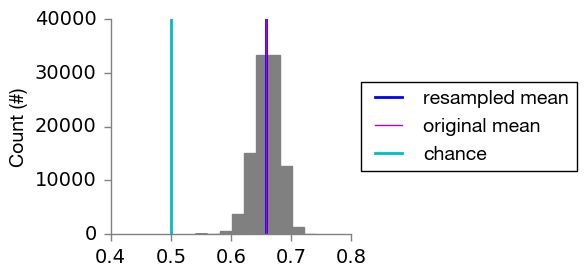

Memory sensitivity for frequent items above chance (.5): p = 1.00E-05
Rejects the null hypothesis that the data is normally distributed, p = 1.36E-03
Parametric statistical result: T = 7.5, p = 1.9E-08


In [17]:
#Compute  statistics on memory sensitivity for frequent items 

data = aFreq
chance = .5

#nonparametric statistics - by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory sensitivity for frequent items above chance (.5): p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

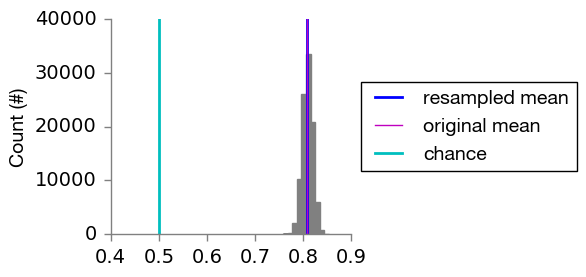

Memory sensitivity for infrequent items above chance (.5): p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.36
Parametric statistical result: T = 28.4, p = 9.6E-24


In [18]:
#Compute  statistics on memory sensitivity for infrequent items 

data = aInfreq
chance = .5

#nonparametric statistics - by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory sensitivity for infrequent items above chance (.5): p = %.2E" %p

#parametric statistics 
paramStatistics(data,chance)

Memory sensitivity for infrequent items - frequent items 0.15


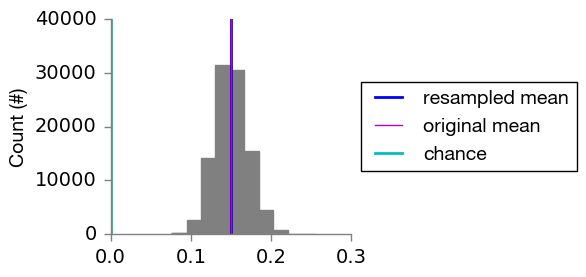

Memory sensitivity for infrequent items > frequent items: p = 1.00E-05
Rejects the null hypothesis that the data is normally distributed, p = 1.42E-02
Parametric statistical result: T = 7.2, p = 4.6E-08


In [19]:
#Compute  statistics on memory sensitivity being greater for infrequent items than frequent items

data = aInfreq-aFreq
chance = 0

print "Memory sensitivity for infrequent items - frequent items %.2f" %np.mean(data)

#nonparametric statistics - by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory sensitivity for infrequent items > frequent items: p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

In [20]:
#print memory performance for infrequent old items (infrequent images that had appeared in the sustained attention phase)

print "Infrequent old items:"
print "Hits = %d%%, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(hInfreq)*100,hInfreqOld_CIs[0],hInfreqOld_CIs[1] )
print "Misses = %d%%, \t95%% CIs %.2f,%.2f" % ( np.ndarray.mean(np.subtract(1,hInfreq))*100,mInfreqOld_CIs[0],mInfreqOld_CIs[1] )

Infrequent old items:
Hits = 38%, 	95% CIs 0.33,0.44
Misses = 61%, 	95% CIs 0.56,0.67


In [21]:
#relate RTs (detrended) to memory performance

#high-confidence old resps only
thresh = 4
nShifts = 3

oldInfreqTrialsAttOrder,oldInfreqTrialsAttnAccs = {},{}
prevRTsDetrend_AttOrderInfreq_Shifts = {}

oldInfreqTrialsRTsPreceding = {}
memoryPerf, rememberedItems,forgottenItems = {},{},{}
RTs_detrended_AttOrderInfreq,binarizedMemoryPerf_AttOrderInfreq = {},{}
est,logistFunctionParams = {},np.zeros([2,nSubj])

for iSubj in range(0,nSubj):  
    #old infrequent trials, according to the location they appear in the memory test
    #note: we subtract one to account for the indexing difference between matlab and python
    oldInfreqTrialsAttOrder[iSubj] = np.subtract(attOrder[iSubj][memCategs[iSubj]==2].astype(int),1) #MAYBE DONT SUBTRACT
    
    #pre-allocate variables
    prevRTsDetrend_AttOrderInfreq_Shifts[iSubj] = np.empty([nShifts,np.size(oldInfreqTrialsAttOrder[iSubj])])*np.NAN
    
    #loop through the various shifts
    for iShift in range(1,(nShifts+1)):
        #shift backwards the locations of the infrequent trial
        trialsShifted = np.subtract(oldInfreqTrialsAttOrder[iSubj],iShift)

        #exclude those trials that, when maximally shifted, are before the start of the run
        wherePos_MaxShifted = np.where(trialsShifted>=0)[0]
        
        #replace the row with the rts (corresponding to that shift)
        prevRTsDetrend_AttOrderInfreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rtsDetrend[iSubj][trialsShifted[wherePos_MaxShifted]]
    
    #memoryPerf[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh)
    rememberedItems[iSubj] = np.where(np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh))[0]
    forgottenItems[iSubj] = np.where(np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh))[0]
    
    #logistic fit
    RTs_detrended_AttOrderInfreq[iSubj] = np.nanmean(prevRTsDetrend_AttOrderInfreq_Shifts[iSubj],axis=0)
    binarizedMemoryPerf_AttOrderInfreq[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh)*1
    if any(np.isnan(RTs_detrended_AttOrderInfreq[iSubj])): #to exclude the bound
        binarizedMemoryPerf_AttOrderInfreq[iSubj] = binarizedMemoryPerf_AttOrderInfreq[iSubj][~np.isnan(RTs_detrended_AttOrderInfreq[iSubj])]
        RTs_detrended_AttOrderInfreq[iSubj] = RTs_detrended_AttOrderInfreq[iSubj][~np.isnan(RTs_detrended_AttOrderInfreq[iSubj])]
    est[iSubj] = sm.GLM(np.vstack([binarizedMemoryPerf_AttOrderInfreq[iSubj],1-binarizedMemoryPerf_AttOrderInfreq[iSubj]]).T,sm.add_constant(RTs_detrended_AttOrderInfreq[iSubj]),family=sm.families.Binomial()).fit()
    logistFunctionParams[:,iSubj] = est[iSubj].params
    
#slope of logistic function
beta = logistFunctionParams[1,:]

#confidence intervals
beta_CIs = bootstrap.ci(data=(beta), statfunction=scipy.mean,n_samples=nSamples)

#print
print "Mean beta %.2f,  95%% CIs %.2f, %.2f" %(np.mean(beta), beta_CIs[0], beta_CIs[1])

Mean beta 1.07,  95% CIs -0.18, 2.17


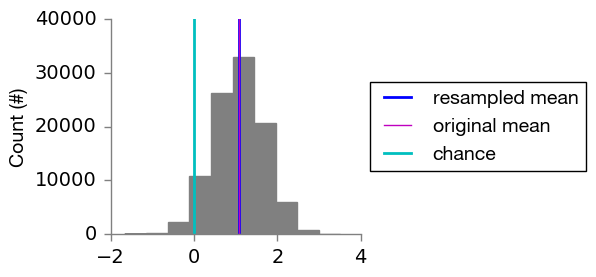

Relationship between slower RT and better memory: p = 3.76E-02
Fails to reject the null hypothesis that the data is normally distributed, p = 0.65
Parametric statistical result: T = 1.8, p = 8.7E-02


In [22]:
#Compute statistics on the relationship between RT and memory performance

data = beta
chance = 0

#nonparametric statistics - by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Relationship between slower RT and better memory: p = %.2E" %p

#paramtric statistics 
paramStatistics(data,chance)

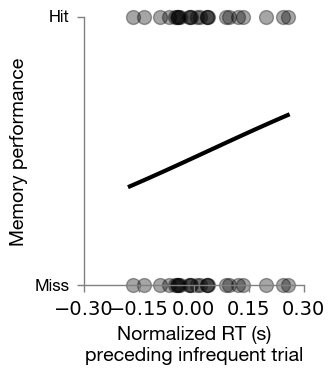

In [23]:
#plot single subject attention-to-memory data (Figure 2b)

iSubj = 5
ax = plt.subplot(121)
ax.scatter(RTs_detrended_AttOrderInfreq[iSubj][rememberedItems[iSubj]],np.ones([np.size(rememberedItems[iSubj])]),s=100,color='k',linewidth=1,alpha=0.35,clip_on=False)
ax.scatter(RTs_detrended_AttOrderInfreq[iSubj][forgottenItems[iSubj]],np.zeros([np.size(forgottenItems[iSubj])]),s=100,color='k',linewidth=1,alpha=0.35,clip_on=False)
inds = np.argsort(RTs_detrended_AttOrderInfreq[iSubj])
ax.plot(RTs_detrended_AttOrderInfreq[iSubj][inds],est[iSubj].fittedvalues[inds],'k',linewidth=3)
make_plot_pretty(ax,ylrot=90,yl='Memory performance',xlim=(-.3,.3),ylim=([0,1]),xt=([-.3,-.15,0,.15,.3]),
                 xl=('Normalized RT (s)\npreceding infrequent trial'),
                 yt=([0,1]),ytl=('Miss','Hit')) 
plt.show()

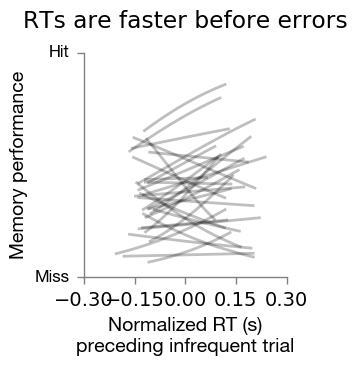

In [24]:
#plot all subjects attention-to-memory data (Figure 2c)

#range of values to be included
lb=4
ub=46

ax = plt.subplot(121)
for iSubj in range(0,nSubj):
    inds = np.argsort(RTs_detrended_AttOrderInfreq[iSubj])
    ax.plot(RTs_detrended_AttOrderInfreq[iSubj][inds[lb:ub]],est[iSubj].fittedvalues[inds[lb:ub]],'k',linewidth=2,alpha=.25)
    
make_plot_pretty(ax,ylrot=90,yl='Memory performance',xlim=(-.3,.3),ylim=([0,1]),xt=([-.3,-.15,0,.15,.3]),
                 xl=('Normalized RT (s)\npreceding infrequent trial'),
                 t='RTs are faster before errors',
                 yt=([0,1]),ytl=('Miss','Hit')) 
plt.show()

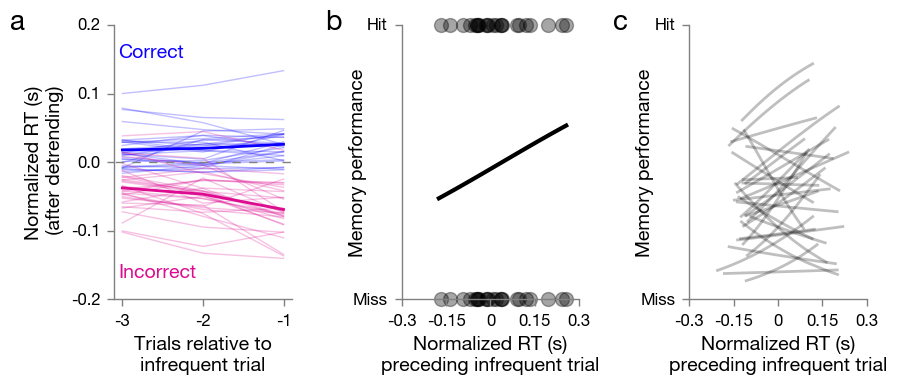

In [25]:
#make Figure 2 for paper 

fig = plt.figure(figsize=(9,4))
gs = plt.GridSpec(1,3)

#FIGURE A
tempmeanCor = np.empty([nShifts,nSubj])*np.nan
tempmeanErr = np.empty([nShifts,nSubj])*np.nan

for iShift in range(0,nShifts):
    for iSubj in range(0,nSubj):
        tempmeanCor[iShift,iSubj] = np.nanmean(prevRTsDetrendInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==1)[0]])
        tempmeanErr[iShift,iSubj] = np.nanmean(prevRTsDetrendInfreq_Shifts[iSubj][iShift,np.where(accs[iSubj][trialsInfreq[iSubj]]==0)[0]])
ax0 = fig.add_subplot(gs[0])
ax0.plot([-1,-2,-3],tempmeanCor,color=[11./255,0,255./255],linewidth=1,alpha=0.25)
ax0.plot([-1,-2,-3],tempmeanErr,color=[220./255,11./255,144./255],linewidth=1,alpha=0.25)
ax0.plot([-1,-2,-3],np.mean(tempmeanCor,axis=1),color=[11./255,0,255./255],linewidth=2,label='Correct')
ax0.plot([-1,-2,-3],np.mean(tempmeanErr,axis=1),color=[220./255,11./255,144./255],linewidth=2,label='Incorrect')
ax0.plot((-3.5,-0.5),(0,0),'--', color='gray',linewidth=1)  

make_plot_pretty(ax0,ylrot=90,yl='Normalized RT (s)\n (after detrending)',ylim=([-.2,.2]),yt=([-0.2,-0.1,0.0,0.1,0.2]),ytl=([-0.2,-0.1,0.0,0.1,0.2]),
                 xlim=(-3.1,-.9),xt=([-3,-2,-1]),xtl=([-3,-2,-1]),
                 xl=('Trials relative to\ninfrequent trial')) 
fig.text(.13, .85, "Correct", size=14,color=[11./255,0,255./255],fontproperties=prop)
fig.text(.13, .3, "Incorrect", size=14,color=[220./255,11./255,144./255],fontproperties=prop)

#FIGURE B
iSubj = 5
ax1 = fig.add_subplot(gs[1])
ax1.scatter(RTs_detrended_AttOrderInfreq[iSubj][rememberedItems[iSubj]],np.ones([np.size(rememberedItems[iSubj])]),s=100,color='k',linewidth=1,alpha=0.35,clip_on=False)
ax1.scatter(RTs_detrended_AttOrderInfreq[iSubj][forgottenItems[iSubj]],np.zeros([np.size(forgottenItems[iSubj])]),s=100,color='k',linewidth=1,alpha=0.35,clip_on=False)
inds = np.argsort(RTs_detrended_AttOrderInfreq[iSubj])
ax1.plot(RTs_detrended_AttOrderInfreq[iSubj][inds],est[iSubj].fittedvalues[inds],'k',linewidth=3)
make_plot_pretty(ax1,ylrot=90,yl='Memory performance',xlim=(-.3,.3),ylim=([0,1]),xt=([-.3,-.15,0,.15,.3]),xtl=([-.3,-.15,0,.15,.3]),
                 xl=('Normalized RT (s)\npreceding infrequent trial'),
                 yt=([0,1]),ytl=('Miss','Hit')) 
ax1.yaxis.labelpad = -10

#FIGURE C
#range of values to be included
lb=4
ub=46

ax2 = fig.add_subplot(gs[2])
for iSubj in range(0,nSubj):
    inds = np.argsort(RTs_detrended_AttOrderInfreq[iSubj])
    ax2.plot(RTs_detrended_AttOrderInfreq[iSubj][inds[lb:ub]],est[iSubj].fittedvalues[inds[lb:ub]],'k',linewidth=2,alpha=.25)
    
make_plot_pretty(ax2,ylrot=90,yl='Memory performance',xlim=(-.3,.3),ylim=([0,1]),xt=([-.3,-.15,0,.15,.3]),xtl=([-.3,-.15,0,.15,.3]),
                 xl=('Normalized RT (s)\npreceding infrequent trial'),yt=([0,1]),ytl=('Miss','Hit')) 
ax2.yaxis.labelpad = -10

fig.text(.01, .92, "a", fontweight='bold',size=20,fontproperties=prop)
fig.text(.36, .92, "b", fontweight='bold',size=20,fontproperties=prop)
fig.text(.68, .92, "c", fontweight='bold',size=20,fontproperties=prop)

savefig(fig,'figure2')

In [26]:
#individual trial lags - relate RTs (detrended) to memory performance


thresh = 4 #high-confidence old resps only
nShifts = 3 #include all 3 shifts

Xshift,y = {},{}
estShift = {}
beta_IndividTrials = np.empty([nSubj,nShifts])
estShift = {}

for iSubj in range(0,nSubj):      
    for iShift in range(0,nShifts):
        #logistic fit
        Xshift[iSubj] = prevRTsDetrend_AttOrderInfreq_Shifts[iSubj][iShift,:]
        y[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh)*1
        if any(np.isnan(Xshift[iSubj])): #to exclude the bound
            y[iSubj] = y[iSubj][~np.isnan(Xshift[iSubj])]
            Xshift[iSubj] = Xshift[iSubj][~np.isnan(Xshift[iSubj])]
        estShift[iSubj] = sm.GLM(np.vstack([y[iSubj],1-y[iSubj]]).T,sm.add_constant(Xshift[iSubj]),family=sm.families.Binomial()).fit()
        #paramsShift[:,iSubj] = est[iSubj].params
        
        beta_IndividTrials[iSubj,iShift] = estShift[iSubj].params[1]

In [27]:
#compute statistics on the logistic funtion for individual trial lags

nShifts = 3

#pre-allocate
pBeta_IndividTrials= np.empty(nShifts)
beta_IndividTrials_CIs = np.empty([nShifts,2])

for iShift in range(0,nShifts):
    #print "Trials i-%i before the infrequent trial:" %( iShift+1 )
    data = beta_IndividTrials[:,iShift]
    chance = 0

    #confidence intervals
    beta_IndividTrials_CIs[iShift,:] = bootstrap.ci(data=(beta_IndividTrials[:,iShift]), statfunction=scipy.mean,n_samples=nSamples)
    
    #Compute nonparametric statistics by resampling participants with replacement
    resampled,p = resamplingStatistics(data,chance,nSubj,nSamples,skipfig=1)
    pBeta_IndividTrials[iShift] = p
    print "RT i-%i: beta = %.2f, (%.2f,%.2f) p = %.4f" % ( iShift+1, np.mean(data),beta_IndividTrials_CIs[iShift,0],beta_IndividTrials_CIs[iShift,1], p )
    
    #paramtric statistics 
    paramStatistics(data,chance)
    
    print " "

RT i-1: beta = 0.88, (-0.10,1.87) p = 0.0382
Fails to reject the null hypothesis that the data is normally distributed, p = 0.86
Parametric statistical result: T = 1.7, p = 9.2E-02
 
RT i-2: beta = 0.69, (-0.43,1.66) p = 0.0992
Fails to reject the null hypothesis that the data is normally distributed, p = 0.32
Parametric statistical result: T = 1.3, p = 2.1E-01
 
RT i-3: beta = 0.68, (-0.29,1.73) p = 0.0928
Fails to reject the null hypothesis that the data is normally distributed, p = 0.61
Parametric statistical result: T = 1.3, p = 2.1E-01
 


In [28]:
#Compare between individual lags - is there a reliable difference in how they predict memory

data = beta_IndividTrials[:,0]-beta_IndividTrials[:,1]
chance = 0
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples,skipfig=1)

print "RT i-1>i-2: betadiff = %.2f, p = %.2f" % (np.mean(data), p )

print " "

data = beta_IndividTrials[:,1]-beta_IndividTrials[:,2]
chance = 0
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples,skipfig=1)

print "RT i-2>i-3: betadiff = %.2f, p = %.2f" % (np.mean(data), p )

RT i-1>i-2: betadiff = 0.19, p = 0.35
 
RT i-2>i-3: betadiff = 0.01, p = 0.49


In [29]:
#individual shifts - relate RTs (detrended) to memory performance

#high-confidence old resps only
thresh = 4
nShifts = 3

Xshift,y = {},{}
estShift = {}
betaShift = np.empty([nSubj,nShifts])

for iSubj in range(0,nSubj):      
    for iShift in range(0,nShifts):
        #logistic fit
        #print np.linspace(0,iShift,iShift+1).astype(int)
        Xshift[iSubj] = np.nanmean(prevRTsDetrend_AttOrderInfreq_Shifts[iSubj][np.linspace(0,iShift,iShift+1).astype(int),:],axis=0)
        y[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh)*1
        if any(np.isnan(Xshift[iSubj])): #to exclude the bound
            y[iSubj] = y[iSubj][~np.isnan(Xshift[iSubj])]
            Xshift[iSubj] = Xshift[iSubj][~np.isnan(Xshift[iSubj])]
        estShift[iSubj] = sm.GLM(np.vstack([y[iSubj],1-y[iSubj]]).T,sm.add_constant(Xshift[iSubj]),family=sm.families.Binomial()).fit()
        #params[:,iSubj] = est[iSubj].params
        
        betaShift[iSubj,iShift] = estShift[iSubj].params[1]

In [30]:
#Calculate RT difference for preceding trials of various window sizes

maxWindow = 5

#high-confidence old resps only
thresh = 4

betaWindowSize = np.empty([maxWindow,nSubj])
pWindowSize = np.empty(maxWindow)

for nShifts in range(1,maxWindow+1):
    
    prevRTsInfreq_Shifts, prevRTsInfreq_ShiftMean = {},{}
    prevRTsDetrendInfreq_Shifts, prevRTsDetrendInfreq_ShiftMean = {},{}
    trialsWithResponses, linfit = {},{}
    
    for iSubj in range(0,nSubj):  
        #pre-allocate variables
        prevRTsInfreq_Shifts[iSubj] = np.empty([nShifts,np.size(trialsInfreq[iSubj])])*np.NAN
        prevRTsDetrendInfreq_Shifts[iSubj] = np.empty([nShifts,np.size(trialsInfreq[iSubj])])*np.NAN

        #loop through the various shifts
        for iShift in range(1,(nShifts+1)):
            #shift backwards the locations of the infrequent trial
            trialsInfreq_Shifted = np.subtract(trialsInfreq[iSubj],iShift)

            #exclude those trials that, when shifted, are before the start of the run
            wherePos_MaxShifted = np.where(trialsInfreq_Shifted>=0)[0]

            #replace the row with the rts (corresponding to that shift)
            prevRTsInfreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rts[iSubj][trialsInfreq_Shifted[wherePos_MaxShifted]]

            #replace the row with the detrended rts (corresponding to that shift)
            prevRTsDetrendInfreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rtsDetrend[iSubj][trialsInfreq_Shifted[wherePos_MaxShifted]]

        #calculate the mean over all shifts
        prevRTsInfreq_ShiftMean[iSubj] = np.nanmean(prevRTsInfreq_Shifts[iSubj],axis=0)
        prevRTsDetrendInfreq_ShiftMean[iSubj] = np.nanmean(prevRTsDetrendInfreq_Shifts[iSubj],axis=0)

    #relate RTs (detrended) to memory performance
    oldInfreqTrialsAttOrder,oldInfreqTrialsAttnAccs = {},{}
    prevRTsDetrend_AttOrderInfreq_Shifts = {}

    oldInfreqTrialsRTsPreceding = {}
    memoryPerf, rememberedItems,forgottenItems = {},{},{}
    X,y = {},{}
    est,params = {},np.zeros([2,nSubj])

    for iSubj in range(0,nSubj):  
        #old infrequent trials, according to the location they appear in the memory test
        #note: we subtract one to account for the indexing difference between matlab and python
        oldInfreqTrialsAttOrder[iSubj] = np.subtract(attOrder[iSubj][memCategs[iSubj]==2].astype(int),1) #MAYBE DONT SUBTRACT

        #pre-allocate variables
        prevRTsDetrend_AttOrderInfreq_Shifts[iSubj] = np.empty([nShifts,np.size(oldInfreqTrialsAttOrder[iSubj])])*np.NAN

        #loop through the various shifts
        for iShift in range(1,(nShifts+1)):
            #shift backwards the locations of the infrequent trial
            trialsShifted = np.subtract(oldInfreqTrialsAttOrder[iSubj],iShift)

            wherePos_MaxShifted = np.where(trialsShifted>=0)[0]
            
            #replace the row with the rts (corresponding to that shift)
            prevRTsDetrend_AttOrderInfreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rtsDetrend[iSubj][trialsShifted[wherePos_MaxShifted]]

        #memoryPerf[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh)
        rememberedItems[iSubj] = np.where(np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh))[0]
        forgottenItems[iSubj] = np.where(np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh))[0]

        #logistic fit
        X[iSubj] = np.nanmean(prevRTsDetrend_AttOrderInfreq_Shifts[iSubj],axis=0)
        y[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==2],thresh)*1
        if any(np.isnan(X[iSubj])): #to exclude the bound
            y[iSubj] = y[iSubj][~np.isnan(X[iSubj])]
            X[iSubj] = X[iSubj][~np.isnan(X[iSubj])]
        est[iSubj] = sm.GLM(np.vstack([y[iSubj],1-y[iSubj]]).T,sm.add_constant(X[iSubj]),family=sm.families.Binomial()).fit()
        params[:,iSubj] = est[iSubj].params

    betaWindowSize[nShifts-1,:] = params[1,:]
    data = params[1,:]
    resampled,p = resamplingStatistics(data,chance,nSubj,nSamples,skipfig=1)
    pWindowSize[nShifts-1] = p
    
    print "Window size = %i" %nShifts
    
    print "Mean beta = %.4f, p = %.4f" %(np.mean(data), p )
    
    paramStatistics(data,chance)
    
    print " "
    
betaWindowSize_CIs = np.empty([maxWindow,2])
RTdiff_windowSize_CIs = np.empty([maxWindow,2])

for iWindow in range(0,maxWindow):
    betaWindowSize_CIs[iWindow,:] = bootstrap.ci(data=(betaWindowSize[iWindow,:]), statfunction=scipy.mean,n_samples=nSamples)
    RTdiff_windowSize_CIs[iWindow,:] = bootstrap.ci(data=(RTdiff_windowSize[iWindow,:]), statfunction=scipy.mean,n_samples=nSamples)

Window size = 1
Mean beta = 0.8844, p = 0.0389
Fails to reject the null hypothesis that the data is normally distributed, p = 0.86
Parametric statistical result: T = 1.7, p = 9.2E-02
 
Window size = 2
Mean beta = 1.0581, p = 0.0331
Fails to reject the null hypothesis that the data is normally distributed, p = 0.44
Parametric statistical result: T = 1.8, p = 7.5E-02
 
Window size = 3
Mean beta = 1.0740, p = 0.0385
Fails to reject the null hypothesis that the data is normally distributed, p = 0.65
Parametric statistical result: T = 1.8, p = 8.7E-02
 
Window size = 4
Mean beta = 1.1360, p = 0.0274
Fails to reject the null hypothesis that the data is normally distributed, p = 0.96
Parametric statistical result: T = 1.9, p = 6.8E-02
 
Window size = 5
Mean beta = 1.2291, p = 0.0217
Fails to reject the null hypothesis that the data is normally distributed, p = 0.88
Parametric statistical result: T = 2.0, p = 5.7E-02
 


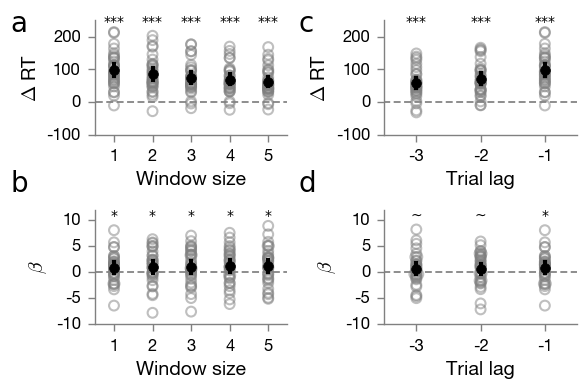

In [31]:
fig = plt.figure(figsize=(6,4))
gs = plt.GridSpec(2,2)

nShifts=3
ax0 = plt.subplot(gs[1])
ax0.plot([-4,0],[0,0],color=[.5,.5,.5],linestyle='--',dashes=(5,2.5),linewidth=1.25)
for iShift in range(0,nShifts):
    x = np.zeros(nSubj)
    y = RTdiff_IndividTrials[iShift,:]
    x_swarm,a,b = plotSpread(x,y)
    ax0.scatter(x_swarm-(iShift+1),y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False,alpha=0.5)
    ax0.plot(-1*(iShift+1),y.mean(),'o',color='k',markersize=7);
    ax0.plot((-1*(iShift+1),-1*(iShift+1)), RTdiff_IndividTrials_CIs[iShift,:], 'k-',linewidth=3);
    ax0.plot((-1*(iShift+1),-1*(iShift+1)), RTdiff_IndividTrials_CIs[iShift,:], 'k-',linewidth=3);
    if pRTdiff_IndividTrials[iShift]<0.001:
        ax0.text(-1*(iShift+1),225,'***',verticalalignment='bottom',horizontalalignment='center',color='k',fontsize=10)
make_plot_pretty(ax0,xt=(-1,-2,-3),xtl=(-1,-2,-3),yt=(-100,0,100,200),ytl=(-100,0,100,200),xlim=(-3.5,-.5),ylim=(-100,250),xl=('Trial lag'),yl=(r'$\Delta$ RT'))

ax2 = plt.subplot(gs[3])
ax2.plot([-4,0],[0,0],color=[.5,.5,.5],linestyle='--',dashes=(5,2.5),linewidth=1.25)
for iShift in range(0,nShifts):
    x = np.zeros(nSubj)
    y = beta_IndividTrials[:,iShift]
    x_swarm,a,b = plotSpread(x,y)
    ax2.scatter(x_swarm-(iShift+1),y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False,alpha=0.5)
    ax2.plot(-1*(iShift+1),(beta_IndividTrials[:,iShift]).mean(),'o',color='k',markersize=7);
    ax2.plot((-1*(iShift+1),-1*(iShift+1)), beta_IndividTrials_CIs[iShift,:], 'k-',linewidth=3);

    if pBeta_IndividTrials[iShift]<0.05:
        ax2.text(-1*(iShift+1),11,'*',verticalalignment='center',horizontalalignment='center',color='k',fontsize=10)
    elif pBeta_IndividTrials[iShift]<0.1:
        ax2.text(-1*(iShift+1),11,'~',verticalalignment='center',horizontalalignment='center',color='k',fontsize=10)
make_plot_pretty(ax2,xt=(-1,-2,-3),xtl=(-1,-2,-3),yt=(-10,-5,0,5,10),ytl=(-10,-5,0,5,10),xlim=(-3.5,-.5),ylim=(-10,12),xl=('Trial lag'),yl=(r"$\beta$"))

ax1 = plt.subplot(gs[0])
ax1.plot([0,6],[0,0],color=[.5,.5,.5],linestyle='--',dashes=(5,2.5),linewidth=1.25)
for iWindow in range(0,maxWindow):
    x = np.zeros(nSubj)
    y = RTdiff_windowSize[iWindow,:]
    x_swarm,a,b = plotSpread(x,y)
    ax1.scatter(x_swarm+(iWindow+1),y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False,alpha=0.5)
    ax1.plot(iWindow+1,(RTdiff_windowSize[iWindow,:]).mean(),'o',color='k',markersize=7);
    ax1.plot((iWindow+1,iWindow+1), RTdiff_windowSize_CIs[iWindow,:], 'k-',linewidth=3);
    if pRTDiffWindowSize[iWindow]<0.001:
        ax1.text((iWindow+1),225,'***',verticalalignment='bottom',horizontalalignment='center',color='k',fontsize=10)
make_plot_pretty(ax1,xt=(1,2,3,4,5),xtl=(1,2,3,4,5),yt=(-100,0,100,200),ytl=(-100,0,100,200),xlim=(.5,5.5),ylim=(-100,250),xl=('Window size'),yl=(r'$\Delta$ RT'))

ax3 = plt.subplot(gs[2])
ax3.plot([0,6],[0,0],color=[.5,.5,.5],linestyle='--',dashes=(5,2.5),linewidth=1.25)
for iWindow in range(0,maxWindow):
    x = np.zeros(nSubj)
    y = betaWindowSize[iWindow,:]
    x_swarm,a,b = plotSpread(x,y)
    ax3.scatter(x_swarm+(iWindow+1),y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False,alpha=0.5)
    ax3.plot(iWindow+1,(betaWindowSize[iWindow,:]).mean(),'o',color='k',markersize=7);
    ax3.plot((iWindow+1,iWindow+1), betaWindowSize_CIs[iWindow,:], 'k-',linewidth=3);

    if pWindowSize[iWindow]<0.05:
        ax3.text(iWindow+1,11,'*',verticalalignment='center',horizontalalignment='center',color='k',fontsize=10)
make_plot_pretty(ax3,xt=(1,2,3,4,5),xtl=(1,2,3,4,5),yt=(-10,-5,0,5,10),ytl=(-10,-5,0,5,10),xlim=(.5,5.5),ylim=(-10,12),xl=('Window size'),yl=(r"$\beta$"))

fig.text(.02, .92, "a", fontweight='medium',size=20)
fig.text(.02, .52, "b", fontweight='medium',size=20)
fig.text(.5, .92, "c", fontweight='medium',size=20)
fig.text(.5, .52, "d", fontweight='medium',size=20)

savefig(fig,'figureS1')

In [32]:
#frequent trials only: calculate preceding RTs

nShifts = 3

trialsFreqMemTest = {}
prevRTsFreqMemTest_Shifts, prevRTsFreqMemTest_ShiftMean = {},{}
prevRTsFreqMemTest_ShiftMean_Cor,prevRTsFreqMemTest_ShiftMean_Err = np.empty(nSubj)*np.NAN, np.empty(nSubj)*np.NAN
nErrs = np.empty(nSubj)*0

for iSubj in range(0,nSubj):      
    trialsFreqMemTest[iSubj] = np.sort(np.subtract(attOrder[iSubj][memCategs[iSubj]==1].astype(int),1)) #categ 1 = old frequent trials
    
    #pre-allocate variables
    prevRTsFreqMemTest_Shifts[iSubj] = np.empty([nShifts,np.size(trialsFreqMemTest[iSubj])])*np.NAN
    
    #loop through the various shifts
    for iShift in range(1,(nShifts+1)):
        #shift backwards the locations of the infrequent trial
        trialsFreqMemTest_Shifted = np.subtract(trialsFreqMemTest[iSubj],iShift)
        
        #exclude those trials that, when shifted, are before the start of the run
        wherePos_MaxShifted = np.where(trialsFreqMemTest_Shifted>=0)[0]
        
        #replace the row with the rts (corresponding to that shift)
        prevRTsFreqMemTest_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rts[iSubj][trialsFreqMemTest_Shifted[wherePos_MaxShifted]]

    #calculate the mean over all shifts
    prevRTsFreqMemTest_ShiftMean[iSubj] = np.nanmean(prevRTsFreqMemTest_Shifts[iSubj],axis=0)
    
    prevRTsFreqMemTest_ShiftMean_Cor[iSubj] = np.nanmean(prevRTsFreqMemTest_ShiftMean[iSubj][np.where(accs[iSubj][trialsFreqMemTest[iSubj]])[0]])

    if np.any(accs[iSubj][trialsFreqMemTest[iSubj]]==0):
        prevRTsFreqMemTest_ShiftMean_Err[iSubj] = np.nanmean(prevRTsFreqMemTest_ShiftMean[iSubj][np.where(accs[iSubj][trialsFreqMemTest[iSubj]]==0)[0]])
        nErrs[iSubj] = np.sum(accs[iSubj][trialsFreqMemTest[iSubj]]==0)
        
print "%i subjects with >3 errors to frequent trials in sustained attention phase" %np.size(np.where(nErrs>3)[0])

2 subjects with >3 errors to frequent trials in sustained attention phase


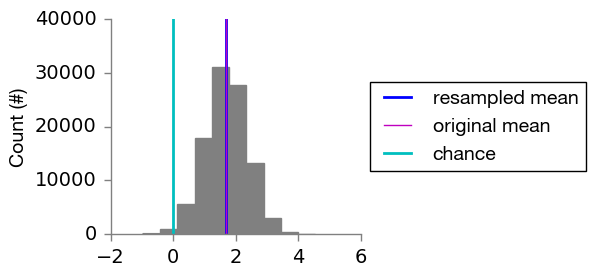

Frequent trials: Mean relationship between RT and memory
Beta = 1.69 (0.33-2.95), p = 0.0060
Fails to reject the null hypothesis that the data is normally distributed, p = 0.75
Parametric statistical result: T = 2.5, p = 1.8E-02


In [33]:
#frequent trials only: relate preceding RTs (detrended) to memory performance

#high-confidence old resps only
thresh = 4
nShifts = 3

oldFreqTrialsAttOrder,oldFreqTrialsAttnAccs = {},{}
prevRTsDetrend_AttOrderFreq_Shifts = {}
oldFreqTrialsRTsPreceding = {}
X,y = {},{}
est,params = {},np.zeros([2,nSubj])

for iSubj in range(0,nSubj):  
    #old infrequent trials, according to the location they appear in the memory test
    #note: we subtract one to account for the indexing difference between matlab and python
    oldFreqTrialsAttOrder[iSubj] = np.subtract(attOrder[iSubj][memCategs[iSubj]==1].astype(int),1) #MAYBE DONT SUBTRACT
    
    #pre-allocate variables
    prevRTsDetrend_AttOrderFreq_Shifts[iSubj] = np.empty([nShifts,np.size(oldFreqTrialsAttOrder[iSubj])])*np.NAN
    
    #loop through the various shifts
    for iShift in range(1,(nShifts+1)):
        #shift backwards the locations of the infrequent trial
        trialsShifted = np.subtract(oldFreqTrialsAttOrder[iSubj],iShift)

        #exclude those trials that, when maximally shifted, are before the start of the run
        wherePos_MaxShifted = np.where(trialsShifted>=0)[0]
        
        #replace the row with the rts (corresponding to that shift)
        prevRTsDetrend_AttOrderFreq_Shifts[iSubj][iShift-1,wherePos_MaxShifted] = rtsDetrend[iSubj][trialsShifted[wherePos_MaxShifted]]
        
    #logistic fit
    X[iSubj] = np.nanmean(prevRTsDetrend_AttOrderFreq_Shifts[iSubj],axis=0)
    y[iSubj] = np.greater_equal(memResps[iSubj][memCategs[iSubj]==1],thresh)*1
    if any(np.isnan(X[iSubj])): #to exclude the bound
        y[iSubj] = y[iSubj][~np.isnan(X[iSubj])]
        X[iSubj] = X[iSubj][~np.isnan(X[iSubj])]
    est[iSubj] = sm.GLM(np.vstack([y[iSubj],1-y[iSubj]]).T,sm.add_constant(X[iSubj]),family=sm.families.Binomial()).fit()
    params[:,iSubj] = est[iSubj].params

betaFreq_CIs = bootstrap.ci(data=(params[1,:]), statfunction=scipy.mean,n_samples=nSamples)

data= params[1,:]
chance = 0
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)

print "Frequent trials: Mean relationship between RT and memory"
print "Beta = %.2f (%.2f-%.2f), p = %.4f" % (np.mean(data) , betaFreq_CIs[0] , betaFreq_CIs[1] ,  p)

paramStatistics(data,chance)